# 0. Imports & constants

In [248]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Latex

from statsmodels.stats.multicomp import pairwise_tukeyhsd

ALPHA = 0.05
GAMMA = 1 - ALPHA

# 1.

In [205]:
np.random.seed(28)

n_features = 30
sample_size = 150

# генерация выборки
X = sp.stats.multivariate_normal(mean=[0] * 30).rvs(sample_size)  # вектор средних - 0, единичная ков. матрица
Y = sp.stats.norm(0, 1).rvs(sample_size)

display(Latex('Проверки гипотез о коэффициенте корреляции $H_0:\ r = 0$'))
denied = 0
for i in range(n_features):
    
    r, pvalue = sp.stats.pearsonr(X[:, i], Y)
    r = round(r, 3)
    pvalue = round(pvalue, 5)
    template = rf"Признак №{i+1}: Значение статистики: {r}. $p = {pvalue}$. "
    if pvalue < ALPHA:
        template += '$H_0$ отвергается.'
        denied += 1
    else:
        template += '$H_0$ не отвергается.'
    display(Latex(template))
print('=' * 20)
print(f'Всего отверглось {denied} нулевых гипотез')

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Всего отверглось 3 нулевых гипотез


In [206]:
# добавить колонку единиц
tmp = np.ones(shape=(sample_size, n_features+1))
tmp[:, 1:] = X
X = tmp
del tmp

In [210]:
# МНК-оценки
beta = np.linalg.lstsq(X, Y, rcond=None)[0]
s2 = (Y - X @ beta).T @ (Y - X @ beta) / (sample_size - n_features - 1)

distr = sp.stats.f(n_features, sample_size - n_features)
f95 = distr.ppf(GAMMA)
print(f'0.95-квантиль распределения Фишера: {round(f95, 3)}')

Tcrit = n_features / (sample_size - n_features) * s2 * f95
print(f'Граница доверительной области: {round(Tcrit, 3)}')

T = beta.T @ (X.T @ X) @ beta
print(f'Значение статистики: {round(T, 3)}')

pval = 1 - distr.cdf(T)
print(f'p = {round(pval, 5)}')

0.95-квантиль распределения Фишера: 1.554
Граница доверительной области: 0.382
Значение статистики: 33.077
p = 0.0


Гипотеза о равенстве 0 коэффициентов регрессии отвергается...
Предположительно тоже вследствие большого числа регрессоров.

In [220]:
for k in (3, 4, 5):
    print('====')
    print(f'Берём первые {k} признаков')
    tmp = X[:, :k+1]
    beta = np.linalg.lstsq(tmp, Y, rcond=None)[0]
    s2 = (Y - tmp @ beta).T @ (Y - tmp @ beta) / (sample_size - k - 1)

    distr = sp.stats.f(k, sample_size -k)
    f95 = distr.ppf(GAMMA)
    print(f'0.95-квантиль распределения Фишера: {round(f95, 3)}')

    Tcrit = k / (sample_size -k) * s2 * f95
    print(f'Граница доверительной области: {round(Tcrit, 3)}')

    T = beta.T @ (tmp.T @ tmp) @ beta
    print(f'Значение статистики: {round(T, 3)}')

    pval = 1 - distr.cdf(T)
    print(f'p = {round(pval, 5)}')

====
Берём первые 3 признаков
0.95-квантиль распределения Фишера: 2.666
Граница доверительной области: 0.056
Значение статистики: 0.285
p = 0.83629
====
Берём первые 4 признаков
0.95-квантиль распределения Фишера: 2.434
Граница доверительной области: 0.069
Значение статистики: 0.601
p = 0.6624
====
Берём первые 5 признаков
0.95-квантиль распределения Фишера: 2.277
Граница доверительной области: 0.08
Значение статистики: 2.664
p = 0.02458


p-value резко падает, как только добавляется признак с относительно высокой корелляцией (0.126 для 5-го признака).

# 2.


In [240]:
# генерация выборки
np.random.seed(28)

n_samples = 100
sample_size = 50

distr = sp.stats.norm(0, 1)
samples = []
for i in range(n_samples):
    samples.append(distr.rvs(size=sample_size))

### a, b)

In [241]:
labels = ['Без поправки', 'Поправка Бонферрони', "Поправка Зидака"]
alphas = [ALPHA, ALPHA / n_samples, 1 - (1 - ALPHA)**(1 / n_samples)]

for alpha, label in zip(alphas, labels):
    rejected = 0
    for X in samples:
        T, pvalue = sp.stats.ttest_1samp(X, 0)
        if pvalue < alpha:
            rejected += 1
    print(label + ':') # f'отвергнуто {rejected} гипотез') 
    display(Latex(rf'$\alpha = {round(alpha, 6)}$, отвергнуто ${rejected}$ гипотез'))

Без поправки:


<IPython.core.display.Latex object>

Поправка Бонферрони:


<IPython.core.display.Latex object>

Поправка Зидака:


<IPython.core.display.Latex object>

### c)

In [247]:
labels = ['Без поправки', 'Поправка Бонферрони',] 

# всего гипотез:
m = n_samples * (n_samples - 1) / 2

alphas = [ALPHA, ALPHA / m,] 

for alpha, label in zip(alphas, labels):
    rejected = 0
    total = 0
    for i in range(n_samples):
        for j in range(i, n_samples):
            total += 1
            X1, X2 = samples[i], samples[j]
            T, pvalue = sp.stats.ttest_ind(X1, X2)
            if pvalue < alpha:
                rejected += 1
    print(label + ':') # f'отвергнуто {rejected} гипотез') 
    display(Latex(rf'$\alpha = {round(alpha, 7)}$, отвергнуто ${rejected}$ гипотез'))

Без поправки:


<IPython.core.display.Latex object>

Поправка Бонферрони:


<IPython.core.display.Latex object>

### d)

In [263]:
# подогнать данные под нужный statsmodels формат
observations = []
for i, X in enumerate(samples):
    for x in X:
        observations.append({'value': x, 'group': i})
df = pd.DataFrame(observations)
df

,value,group
0,0.446332,0
1,1.669120,0
2,-0.264280,0
3,-0.967835,0
4,0.059188,0
...,...,...
4995,-0.617671,99
4996,0.297020,99
4997,-1.120810,99
4998,-1.531461,99


In [279]:
tukey = pairwise_tukeyhsd(endog=df['value'], groups=df['group'], alpha=ALPHA)
display(Latex(fr'Тест Тьюки, $\alpha = {ALPHA}$; отклонено {sum(tukey.reject)} гипотез.'))

<IPython.core.display.Latex object>

# 3.

In [280]:
# генерация выборки
np.random.seed(28)

n_samples = 100
sample_size = 50

samples = []
for i in range(n_samples):
    distr = sp.stats.norm(-1 + 2 * i / 99)
    samples.append(distr.rvs(size=sample_size))

In [292]:
border = 20  # число разделающих символов при выводе
print('=' * border)

 
print('a, b) Гипотезы о равенстве нулю среднего')
labels = ['Без поправки', 'Поправка Бонферрони', "Поправка Зидака"]
alphas = [ALPHA, ALPHA / n_samples, 1 - (1 - ALPHA)**(1 / n_samples)]

for alpha, label in zip(alphas, labels):
    rejected = 0
    for X in samples:
        T, pvalue = sp.stats.ttest_1samp(X, 0)
        if pvalue < alpha:
            rejected += 1
    print(label + ':') # f'отвергнуто {rejected} гипотез') 
    display(Latex(rf'$\alpha = {round(alpha, 6)}$, отвергнуто ${rejected}$ гипотез'))
print('=' * border)
    
    
print('c) Гипотезы о равенстве средних для всех пар')
labels = ['Без поправки', 'Поправка Бонферрони',] 
# всего гипотез:
m = n_samples * (n_samples - 1) / 2

alphas = [ALPHA, ALPHA / m,] 

for alpha, label in zip(alphas, labels):
    rejected = 0
    total = 0
    for i in range(n_samples):
        for j in range(i, n_samples):
            total += 1
            X1, X2 = samples[i], samples[j]
            T, pvalue = sp.stats.ttest_ind(X1, X2)
            if pvalue < alpha:
                rejected += 1
    print(label + ':') # f'отвергнуто {rejected} гипотез') 
    display(Latex(rf'$\alpha = {round(alpha, 7)}$, отвергнуто ${rejected}$ гипотез'))
print('=' * border)
    

print('d) Гипотезы о равенстве средних для всех пар - тест Тьюки')
observations = []
for i, X in enumerate(samples):
    for x in X:
        observations.append({'value': x, 'group': i})
df = pd.DataFrame(observations)
tukey = pairwise_tukeyhsd(endog=df['value'], groups=df['group'], alpha=ALPHA)
display(Latex(fr'Тест Тьюки, $\alpha = {ALPHA}$; отклонено {sum(tukey.reject)} гипотез.'))

a, b) Гипотезы о равенстве нулю среднего
Без поправки:


<IPython.core.display.Latex object>

Поправка Бонферрони:


<IPython.core.display.Latex object>

Поправка Зидака:


<IPython.core.display.Latex object>

c) Гипотезы о равенстве средних для всех пар
Без поправки:


<IPython.core.display.Latex object>

Поправка Бонферрони:


<IPython.core.display.Latex object>

d) Гипотезы о равенстве средних для всех пар - тест Тьюки


<IPython.core.display.Latex object>

# 4.

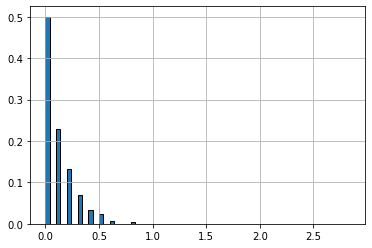

In [369]:
# генерация выборки
np.random.seed(28)
lam = 7
X = np.random.exponential(scale=1/lam, size=400)

bins = np.arange(0, 3, 0.1)
hist, edges = np.histogram(X, bins)
freq = hist/float(hist.sum())

plt.bar(bins[:-1],freq, width=0.04, align="edge", ec="k" )
tmp = np.linspace(0, 2)
plt.grid()
plt.show()

In [385]:
def F_H0(x, lam=6):
    return np.where(x >= 0, 1 - np.exp(-lam * x), 0) 

m = 398  # количество гипотез

# независимая проверка гипотез
results = []
for i in range(398):
    subsample = X[i:]
    T, pval = sp.stats.kstest(subsample, F_H0)
    results.append((i+1, pval))
    
# Алгоритм Хольма
rejected = 0
results.sort(key=lambda x: x[1])
for i, res in enumerate(results):
    hypothesis_number, pval = res
    if pval < ALPHA / (m - i):
        rejected += 1
    else:
        break
print(f'Алгоритм Хольма: отвергнуто {rejected} гипотез')

Алгоритм Хольма: отвергнуто 0 гипотез


In [389]:
results[0][1] < ALPHA / m

False

In [393]:
results[0]

(95, 0.008774287750466568)

In [395]:
p_adj = ALPHA / m
round(p_adj, 5)

0.00013

Видно, для всех гипотез $p$ не ниже, чем $0.05$ с поправкой Бонферрони  (поскольку этот порог не проходит наименьшее из $p$-значений), т.е. ни одна гипотеза не отвергнется (что можно частично объяснить консервативностью критерия).